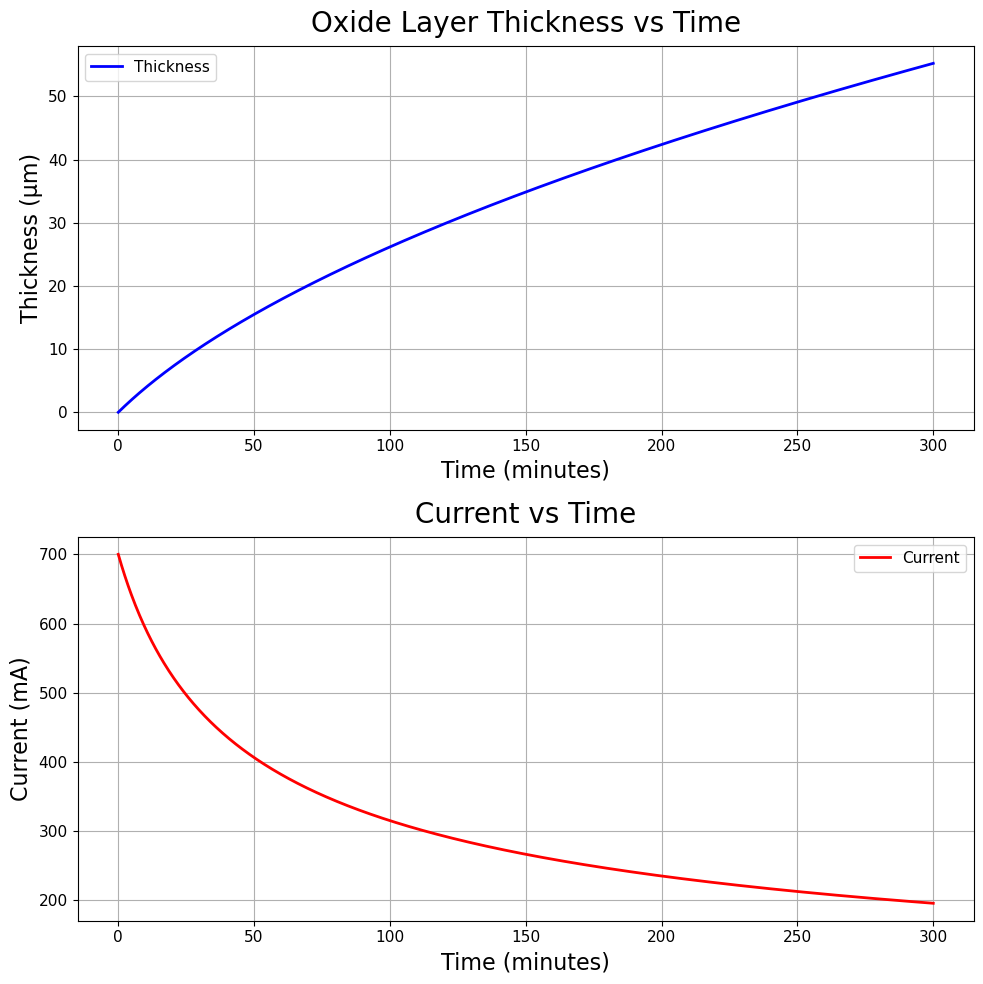

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from dataclasses import dataclass
from typing import Tuple, Optional

@dataclass
class SimulationResults:
    """Container for simulation results"""
    time_points: np.ndarray
    thickness_values: np.ndarray
    current_values: np.ndarray

class AnodizationSimulator:
    def __init__(
        self,
        M: float,
        x: int,
        y: int,
        Density: float,
        rho: float,
        F: float,
        A: float,
        I0: float,
        V: float,
        pores_density: float = 0.6,
        total_time: float = 18000,          # Total anodization time 
        num_points: int = 1000,
        efficiency: float = 1
    ):
        """
        Initialize anodization simulation parameters
        
        Args:
            M: Molar mass of the compound (kg/mol)
            x: Valence of first oxide's atom (e.g., Al in AlxOy)
            y: Valence of second oxide's atom (e.g., O in AlxOy)
            Density: Density (kg/m³)
            rho: Resistivity (Ω·m)
            F: Faraday's constant (C/mol)
            A: Surface area (m²)
            I0: Initial current (A)
            V: Applied voltage (V)
            pores_density: Fraction of porous space (default: 0.4)
            total_time: Total simulation time in seconds (default: 18000)
            num_points: Number of simulation points (default: 1000)
            efficiency: Anodization efficiency factor (default: 0.95)
        """
        self._validate_inputs(M, x, y, Density, rho, F, A, I0, V, 
                            pores_density, total_time, num_points, efficiency)
        
        self.M = M
        self.x = x
        self.y = y
        self.Density = Density * (1 - pores_density)
        self.rho = rho
        self.F = F
        self.A = A
        self.I0 = I0
        self.V = V
        self.total_time = total_time
        self.num_points = num_points
        self.efficiency = efficiency
        self.MIN_THICKNESS = 1e-10  # 0.1 nm minimum thickness
        self.dt = total_time / num_points

    @staticmethod
    def _validate_inputs(*args):
        """Validate that all input parameters are positive"""
        if any(arg <= 0 for arg in args):
            raise ValueError("All parameters must be positive")
        
    def current_decay(self, t: float, thickness: float) -> float:
        """
        Model current decay over time using Ohm's law
        
        Args:
            t: Time in seconds
            thickness: Current oxide layer thickness (m)
            
        Returns:
            float: Current at time t in amperes
        """
        if thickness <= self.MIN_THICKNESS:
            return self.I0
    
        return min(self.V / (self.rho * thickness / self.A + self.V / self.I0), self.I0)
    
    def thickness_rate(self, thickness: float, t: float) -> float:
        """
        Calculate the rate of thickness change using Faraday's law
        
        Args:
            thickness: Current thickness in meters
            t: Time in seconds
            
        Returns:
            float: Rate of thickness change (m/s)
        """            
        current = self.current_decay(t, thickness)
        
        return (current * self.M * self.efficiency * self.dt) / \
            (self.x * self.y * self.Density * self.F * self.A)
        
    def simulate(self) -> SimulationResults:
        """
        Run the simulation
        
        Returns:
            SimulationResults: Container with simulation results
        """
        time_points = np.linspace(0, self.total_time, self.num_points)
        thickness_values = np.zeros(self.num_points)
        thickness_values[0] = self.MIN_THICKNESS
        current_values = np.zeros(self.num_points)
        current_values[0] = self.I0
        
        for i in range(1, self.num_points):
            # Calculate new thickness using previous thickness and rate
            rate = self.thickness_rate(thickness_values[i-1], time_points[i-1])
            thickness_values[i] = thickness_values[i-1] + rate * self.dt
            
            # Calculate current at this time point
            current_values[i] = self.current_decay(time_points[i], thickness_values[i])
        
        return SimulationResults(
            time_points=time_points,
            thickness_values=thickness_values,
            current_values=current_values
        )
    
    def plot_results(self, results: SimulationResults, save_path: Optional[str] = None) -> plt.Figure:
        """
        Plot the simulation results
        
        Args:
            results: SimulationResults container
            save_path: Optional path to save the figure
            
        Returns:
            matplotlib.figure.Figure: Figure containing the plots
        """

        # Set font sizes
        plt.rcParams.update({
            'font.size': 12,
            'axes.titlesize': 20,
            'axes.labelsize': 12,
            'xtick.labelsize': 11,
            'ytick.labelsize': 11,
            'legend.fontsize': 11
        })
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot thickness vs time
        ax1.plot(results.time_points/60, results.thickness_values*1e6, 'b-', 
                label='Thickness', linewidth=2)
        ax1.set_xlabel('Time (minutes)', fontsize=16)
        ax1.set_ylabel('Thickness (μm)', fontsize=16)
        ax1.set_title('Oxide Layer Thickness vs Time', fontsize=20, pad=10)
        ax1.grid(True)
        ax1.legend(fontsize=11)
        
        # Plot current vs time
        ax2.plot(results.time_points/60, results.current_values*1000, 'r-', 
                label='Current', linewidth=2)
        ax2.set_xlabel('Time (minutes)', fontsize=16)
        ax2.set_ylabel('Current (mA)', fontsize=16)
        ax2.set_title('Current vs Time', fontsize=20, pad=10)
        ax2.grid(True)
        ax2.legend(fontsize=11)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        return fig

def main():
    """Example usage of the simulator"""
    # Example parameters for aluminum oxide (Al2O3) anodization
    params = {
        'M': 0.102,      # Molar mass of Al2O3 (kg/mol)
        'x': 2,          # Number of Al atoms
        'y': 3,          # Number of O atoms
        'Density': 3950, # Density of Al2O3 (kg/m³)
        'rho': 8e5,      # Resistivity of Al2O3 (Ω·m)
        'F': 96485,      # Faraday's constant (C/mol)
        'A': 0.2,        # Surface area (m²)
        'I0': 0.7,       # Initial current (A)
        'V': 60,         # Applied voltage (V)
    }
    
    try:
        # Create simulator instance and run simulation
        simulator = AnodizationSimulator(**params)
        results = simulator.simulate()
        
        # Plot and display results
        fig = simulator.plot_results(results)
        plt.show()
        
    except ValueError as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()